#### Customer data

In [113]:
# Importing lots of stuff

import logging
import threading
import itertools
import pandas as pd
import numpy as np 
import scipy as sp
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (BayesRidgeRegressor)                
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
from sklearn import preprocessing
import seaborn as sns
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [114]:
'''
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
    
db_schema=None
db = Database(credentials=credentials)
print (db)
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)
'''

"\nwith open('credentials_as_monitor_demo.json', encoding='utf-8') as F:\n    credentials = json.loads(F.read())\n    \ndb_schema=None\ndb = Database(credentials=credentials)\nprint (db)\ndb_schema=None\nfm = FileModelStore()\ndb = Database(credentials=credentials, model_store=fm)\nprint (db)\n"

In [115]:
df_input = pd.read_csv('BP_DATA/IoTData.csv', parse_dates=['DATETIME'], comment='#')

In [116]:
df_input.rename(columns={'DATETIME': 'timestamp'}, inplace=True)


In [117]:
df_input

,timestamp,TEMP_AIR,UMIDADE_REL,KW,KW2
0,2019-09-15 00:00:00,18.7,80,690.480000,69.048000
1,2019-09-15 01:00:00,18.2,83,685.440000,68.544000
2,2019-09-15 02:00:00,18.2,83,656.880000,65.688000
3,2019-09-15 03:00:00,18.2,83,655.200000,65.520000
4,2019-09-15 04:00:00,18.3,82,660.240000,66.024000
...,...,...,...,...,...
8331,2020-08-31 16:00:00,20.8,68,525.840027,52.584003
8332,2020-08-31 17:00:00,19.6,72,504.000000,50.400000
8333,2020-08-31 18:00:00,19.5,75,535.919983,53.591998
8334,2020-08-31 19:00:00,19.0,76,517.440003,51.744000


(8335,)


/home/markus/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


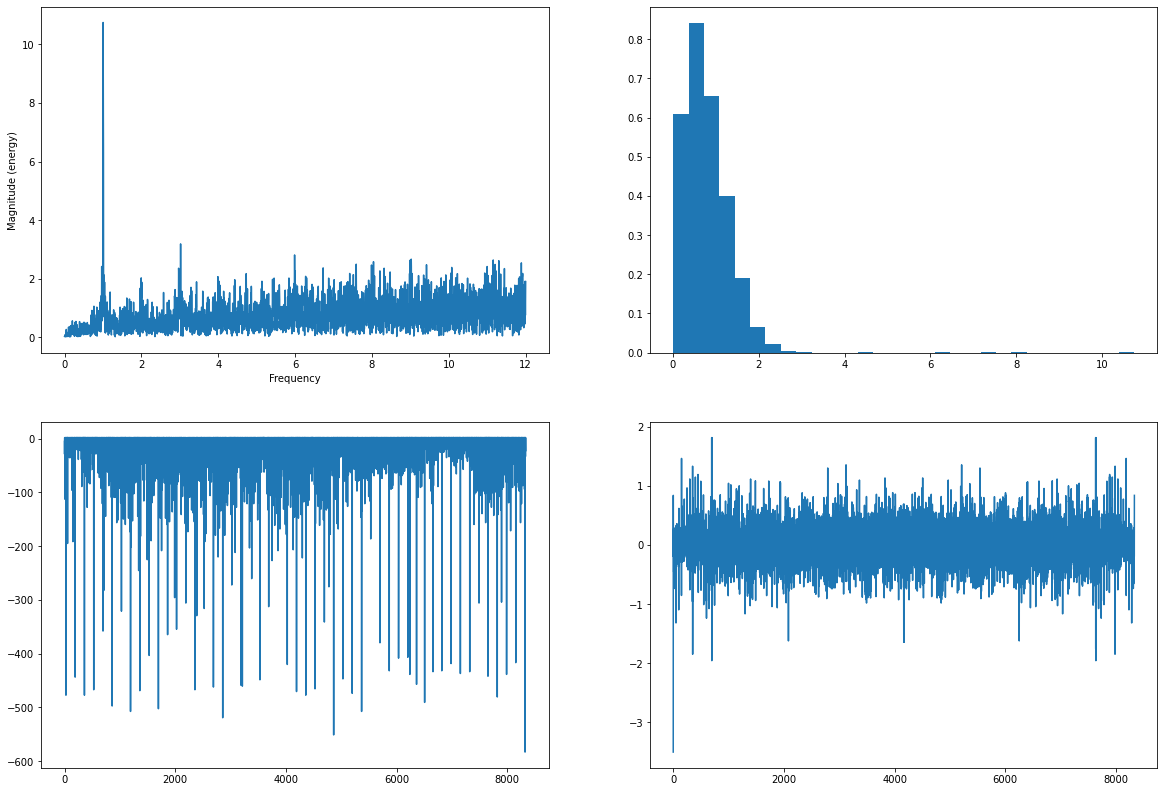

In [293]:
# seasonality - once a day stands out, every 3 days
ndif_ = np.diff(df_input['KW'])
ndif_fft = sp.fft.fft(ndif_)

print (ndif_.shape)
fig, ax = plt.subplots(2,2,figsize=(20,14))
spectrum,_,_ = ax[0,0].magnitude_spectrum(ndif_, Fs=24)
ndif_[ndif_ > 2] = 2
ndif2 = sp.fft.ifft(ndif_)
ndif2[ndif2 < -3.5] = -3.5
t = ax[1,0].plot(np.arange(0,np.size(ndif_)), ndif_)
t = ax[0,1].hist(spectrum, bins=30, density=True)
t = ax[1,1].plot(ndif2)
#print(ndif_.mode())

ndif = np.real(ndif2)

In [287]:
ndif.shape

(8335,)

In [294]:
ptfd = preprocessing.PowerTransformer()
kw_boxed = ptfd.fit_transform(ndif.reshape(-1, 1))
kw_log = np.lib.scimath.log(ndif)


/home/markus/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/markus/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:904: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)


/home/markus/.local/lib/python3.8/site-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/home/markus/.local/lib/python3.8/site-packages/matplotlib/transforms.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


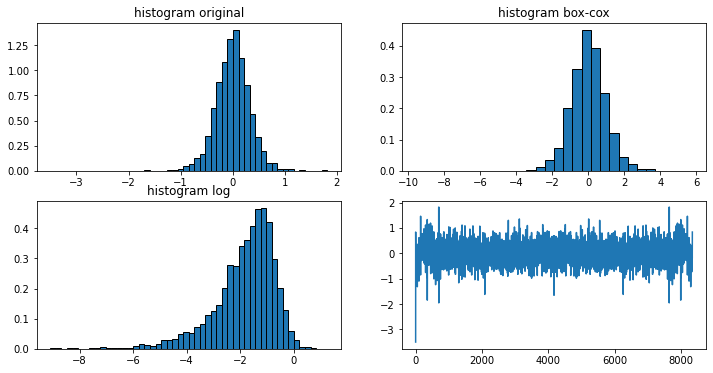

In [296]:
fig, ax = plt.subplots(2, 2,figsize=(12,6), squeeze=False)

ax[0,0].hist(ndif, bins=50, density = True, histtype='bar', ec='black')
ax[0,0].set_title('histogram original')
ax[0,1].hist(kw_boxed, bins=30, density = True, histtype='bar', ec='black')
ax[0,1].set_title('histogram box-cox')
ax[1,0].hist(kw_log, bins=50, density = True, histtype='bar', ec='black')
ax[1,0].set_title('histogram log')
ax[1,1].plot(ndif)

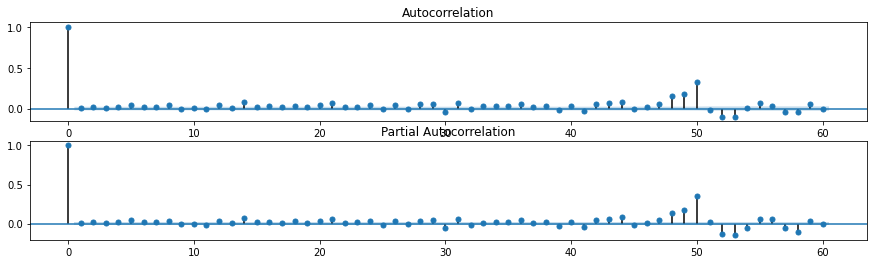

In [297]:
#
# p = 1, q = 1 + seasonal effects
#
fig, ax = plt.subplots(2, 1, figsize=(15, 4), squeeze=False)
x = sm.graphics.tsa.plot_acf(ndif, lags=60, ax=ax[0,0])
x = sm.graphics.tsa.plot_pacf(ndif, lags=60, ax=ax[1,0])

In [118]:

ptf = preprocessing.PowerTransformer(method='box-cox')
kw_boxed = ptf.fit_transform(df_input['KW'].values.reshape(-1,1))
df_input['KW_box'] = kw_boxed

df_input['KW_log'] = np.lib.scimath.log(df_input['KW'].values)

#kw_unboxed = ptf.inverse_transform(kw_boxed)
#kw_unboxed - df_input['KW'].values.reshape(-1,1)

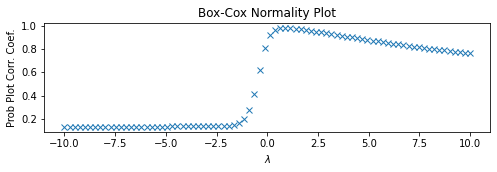

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(8,2), squeeze=False)
prob = sp.stats.boxcox_normplot(df_input['KW'].values, -10, 10, plot=ax[0,0])


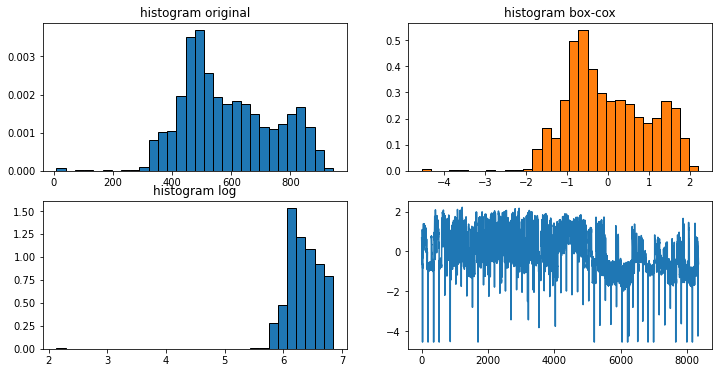

In [120]:
fig, ax = plt.subplots(2, 2,figsize=(12,6), squeeze=False)

ax[0,0].hist(df_input['KW'], bins=30, density = True, histtype='bar', ec='black')
ax[0,0].set_title('histogram original')
ax[0,1].hist(df_input['KW_box'], bins=30, density = True, histtype='bar', ec='black')
#ax[0,1].hist(df_input['KW_box'], bins=30, density = True, histtype='bar', ec='black')
ax[0,1].set_title('histogram box-cox')
ax[1,0].hist(df_input['KW_log'], bins=30, density = True, histtype='bar', ec='black')
ax[1,0].set_title('histogram log')
ax[1,1].plot(df_input.index, df_input['KW_box'])


In [97]:
# Pick scaled data 

#    - choosing logarithmic scale now

df_scaled = df_input[['KW_log']].copy()
df_scaled.rename(columns={'KW_log':'KW'}, inplace=True)

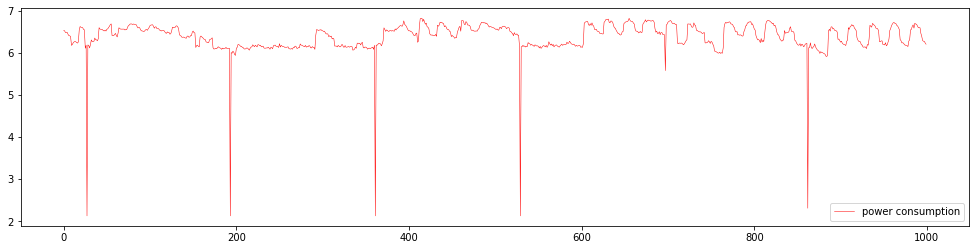

In [98]:
dfg = df_scaled[0:1000]


fig, ax = plt.subplots(1, 1,figsize=(17,4), squeeze=False)
ax[0,0].plot(dfg.index, dfg['KW'], lw=0.5, color='red', label='power consumption')
[ax[i,0].legend() for i in range(1)]
#[ax[i].set_xticks([]) for i in range(4)]
#[ax[i].set_yticks([]) for i in range(5)]

In [31]:
# stationary ? No
import statsmodels.api as sm
sm.tsa.stattools.adfuller(df_scaled)[1]

1.0776703376094801e-11

In [32]:
sm.tsa.stattools.kpss(df_scaled)[1]

/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/markus/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


0.01

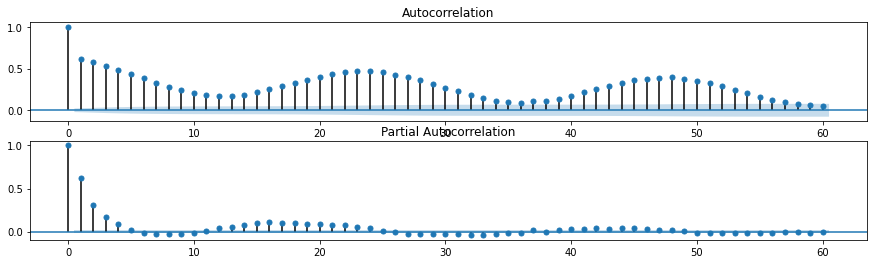

In [106]:
#
# p = 2, q = 0 + seasonal effects
#
fig, ax = plt.subplots(2, 1, figsize=(15, 4), squeeze=False)
x = sm.graphics.tsa.plot_acf(df_scaled, lags=60, ax=ax[0,0])
x = sm.graphics.tsa.plot_pacf(df_scaled, lags=60, ax=ax[1,0])

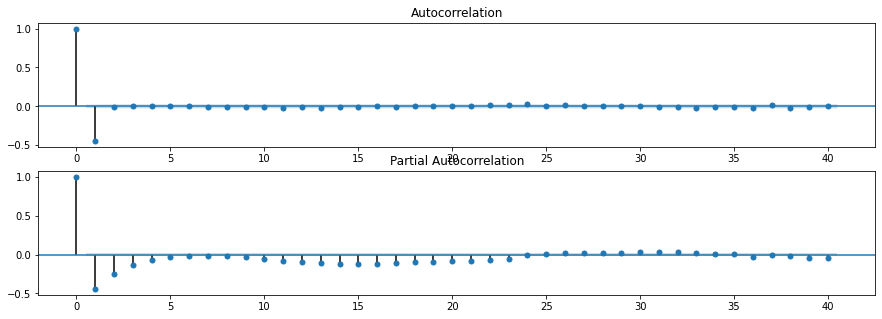

In [107]:
#
#  Maybe it's better to go with 
# p = 1, i = 1 and q = 1 + seasonal effects
#
df_scal_diff = df_scaled.diff().dropna()
fig, ax = plt.subplots(2, 1, figsize=(15, 5), squeeze=False)
x = sm.graphics.tsa.plot_acf(df_scal_diff, lags=40, ax=ax[0,0])
x = sm.graphics.tsa.plot_pacf(df_scal_diff, lags=40, ax=ax[1,0])

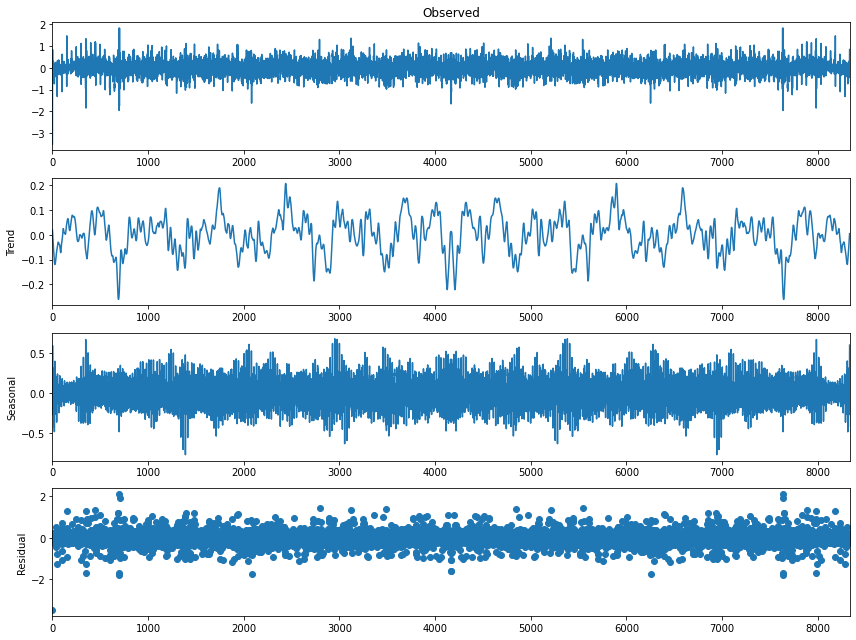

In [298]:
# we have a seasonal component here ...

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import qqplot

plt.rc('figure',figsize=(12,9))
stl = STL(ndif, period=24, robust=True)
res = stl.fit()
fig = res.plot()

In [299]:
# Combine LOESS with ARIMA
stlf111 = STLForecast(ndif[0:6000], ARIMA, model_kwargs=dict(order=(1,0,1), trend="n"), period=7*24)
stlf200 = STLForecast(ndif[0:6000], ARIMA, model_kwargs=dict(order=(1,0,2), trend="n"), period=7*24)

In [300]:
plt.rc('figure',figsize=(18,4))

#kws = df[0:2000].reset_index().drop(columns='timestamp')

stlf_res111 = stlf111.fit()
stlf_res200 = stlf200.fit()

n_fore = 120
forecast111 = stlf_res111.forecast(n_fore)
forecast200 = stlf_res200.forecast(n_fore)



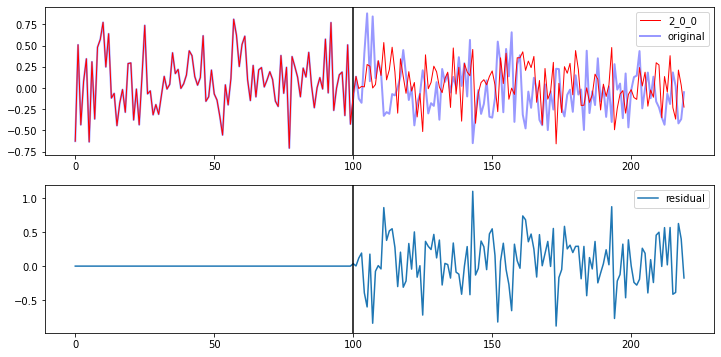

In [301]:
cat111 = np.concatenate((ndif[5900:6000], forecast111))

fig, ax = plt.subplots(2, 1, figsize=(12,6), squeeze=False)
cnt = 0
#ax[cnt,0].plot(np.concatenate((ndif[5900:6000], forecast111)), color='orange', lw=1, label='1_1_1', zorder=10)
ax[cnt,0].plot(cat111, color='red', lw=1, label='2_0_0', zorder=10)
ax[cnt,0].plot(ndif[5900:6000 + n_fore], color='blue', lw=2, label='original', alpha=0.4)
ax[cnt,0].axvline(100,0,1,color='black')
ax[cnt,0].legend()
cnt = 1
ax[cnt,0].plot(cat111 - ndif[5900:6000 + n_fore], label='residual')
ax[cnt,0].axvline(100,0,1,color='black')
ax[cnt,0].legend()


In [252]:
print(stlf_res111.summary(),'\n',stlf_res200.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                 6000
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -31832.481
Date:                Wed, 21 Oct 2020   AIC                          63670.962
Time:                        18:29:17   BIC                          63691.060
Sample:                             0   HQIC                         63677.942
                               - 6000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1389      0.025      5.532      0.000       0.090       0.188
ma.L1         -0.4438      0.027    -16.587      0.000      -0.496      -0.391
sigma2      2381.8949     17.933    132.823      0.0

In [245]:
# Uh-oh - so our residuals show some autocorrelation

from statsmodels.stats.stattools import durbin_watson

print(durbin_watson(stlf_res111.result.resid), durbin_watson(stlf_res200.result.resid))

2.5441341239803315 2.5441341239803315


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

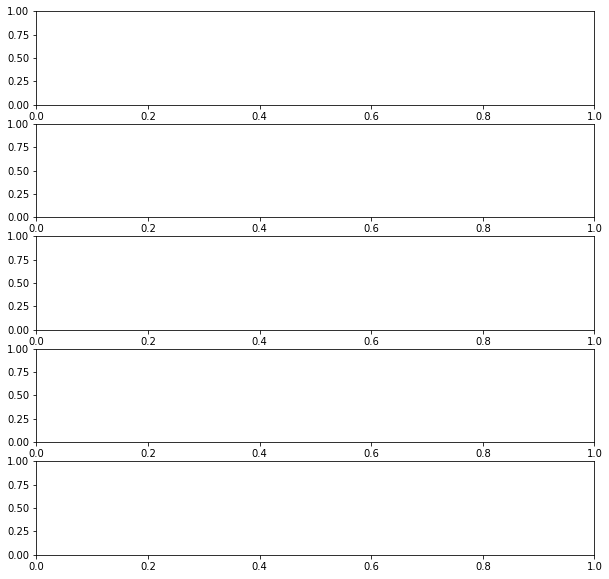

In [246]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10), squeeze=False)
x = stlf_res111.result.resid.plot(ax=ax[0,0])
x = (stlf_res200.result.resid-1).plot(ax=ax[0,0])
x = sm.graphics.tsa.plot_acf(stlf_res111.result.resid, lags=60, ax=ax[1,0])
x = sm.graphics.tsa.plot_acf(stlf_res200.result.resid, lags=60, ax=ax[2,0])
ax[1,0].set_title('')
x = sm.graphics.tsa.plot_pacf(stlf_res111.result.resid, lags=60, ax=ax[3,0])
x = sm.graphics.tsa.plot_pacf(stlf_res200.result.resid, lags=60, ax=ax[4,0])

ax[2,0].set_title('')

kde111 = sm.nonparametric.KDEUnivariate(stlf_res111.result.resid)
kde200 = sm.nonparametric.KDEUnivariate(stlf_res111.result.resid)
kde111.fit()
kde200.fit()

fig, ax = plt.subplots(1, 4, figsize=(16, 4), squeeze=False)
x = ax[0,1].hist(stlf_res111.result.resid, bins=30, density = True)
x = ax[0,1].set_title('Distribution residual - 1,1,1')
x = ax[0,1].plot(kde111.support, kde111.density, lw=2, label='kernel density', color='orange', zorder=10)

x = ax[0,3].hist(stlf_res200.result.resid, bins=30, density = True)
x = ax[0,3].set_title('Distribution residual - 2,0,0')
x = ax[0,3].plot(kde200.support, kde200.density, lw=2, label='kernel density', color='orange', zorder=10)

x = ax[0,0].set_title('QQPlot\nAlmost normal')
x = qqplot(stlf_res111.result.resid, line='q', ax=ax[0,0], fit=True)

x = ax[0,2].set_title('QQPlot\nAlmost normal')
x = qqplot(stlf_res200.result.resid, line='q', ax=ax[0,2], fit=True)

In [255]:
# Trying "plain" ARIMA from pyflux
import pyflux as pf

model = pf.ARIMA(data=df_scaled[0:6000], ar=2, ma=0, target='KW', family=pf.Normal())

In [256]:
x = model.fit("MLE")
x.summary()

Normal ARIMA(2,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: KW                                  Method: MLE                                       
Start Date: 2                                           Log Likelihood: -1287.8973                        
End Date: 5999                                          AIC: 2583.7946                                    
Number of observations: 5998                            BIC: 2610.5913                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0288     0.0042     6.7918   0.0      (0.0205 | 0.0372)        
AR(1)                                

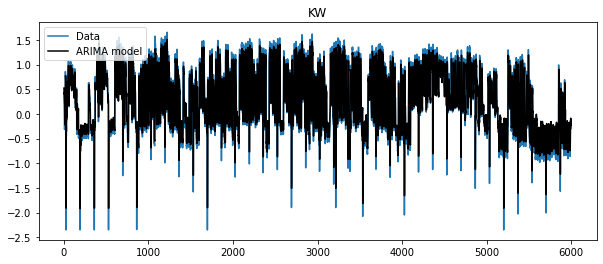

In [259]:
model.plot_fit(figsize=(10,4))

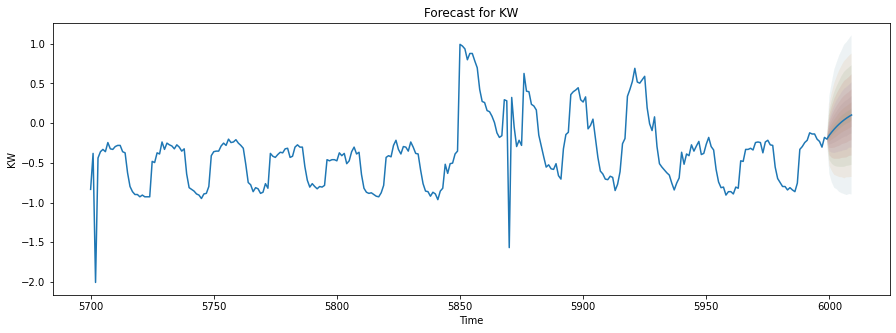

In [271]:
# Hmmm - I wouldn't have expected that
# not sure whether this is useful
#
model.plot_predict(h=10,past_values=300,figsize=(15,5))

In [309]:
# looking for volatility

model = pf.GARCH(p=1, q=1, data=df_scaled[0:1500])

model.adjust_prior(1, pf.TruncatedNormal(0.01, 0.5, lower=0.0, upper=1.0))
model.adjust_prior(2, pf.TruncatedNormal(0.97, 0.5, lower=0.0, upper=1.0))

In [312]:
model.plot_z([1,2], figsize=(10,4))

ValueError: No information on latent variable to plot!

<Figure size 720x288 with 0 Axes>

In [283]:
print(model.latent_variables)

Index    Latent Variable           Prior           Prior Hyperparameters     V.I. Dist  Transform 
======== ========================= =============== ========================= ========== ==========
0        Vol Constant              Normal          mu0: 0, sigma0: 3         Normal     exp       
1        q(1)                      TruncatedNormal mu0: 0.01, sigma0: 0.5    Normal     None      
2        p(1)                      TruncatedNormal mu0: 0.97, sigma0: 0.5    Normal     None      
3        Returns Constant          Normal          mu0: 0, sigma0: 3         Normal     None      


In [288]:
#
# MCMC made easy
#
x = model.fit('M-H', nsims=20000)  # size of the array for the posterior density in latent_variables.z_list

Acceptance rate of Metropolis-Hastings is 0.0003
Acceptance rate of Metropolis-Hastings is 0.0265
Acceptance rate of Metropolis-Hastings is 0.403375
Acceptance rate of Metropolis-Hastings is 0.316

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.319725


In [298]:
mylatent = model.latent_variables

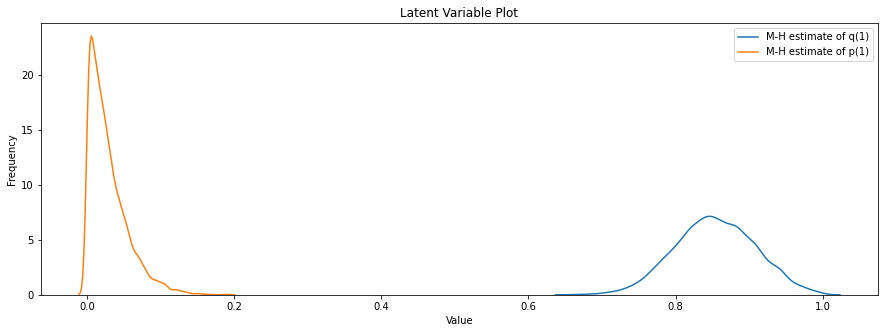

In [71]:
model.plot_z([1,2])

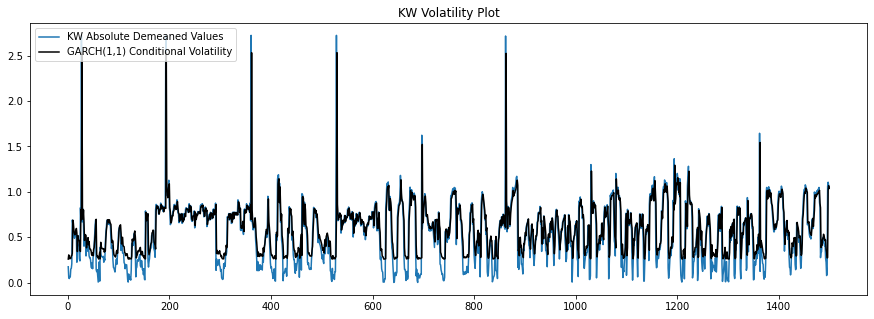

In [72]:
model.plot_fit(figsize=(15,5))

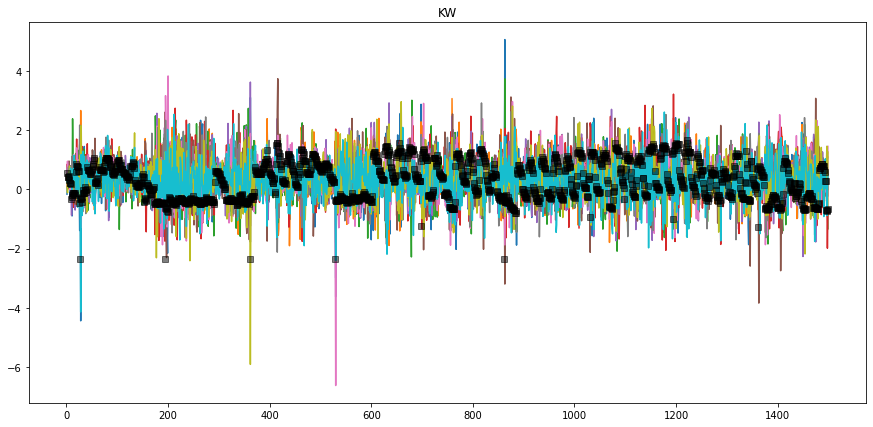

In [73]:
model.plot_sample(nsims=10, figsize=(15,7))

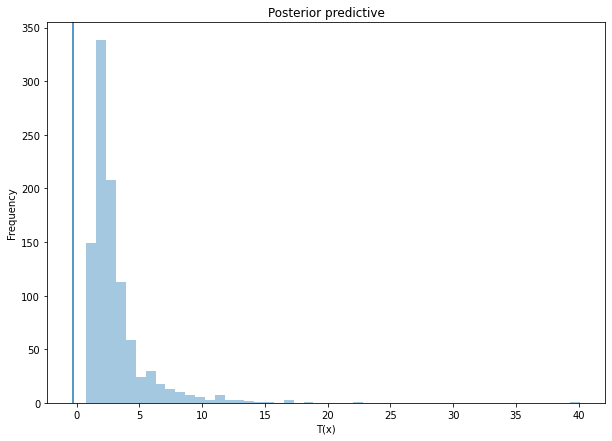

In [74]:
from scipy.stats import kurtosis
model.plot_ppc(T=kurtosis)

In [77]:
x.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: KW                                  Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -1224.9757            
End Date: 1499                                          AIC: 2457.9514348468665                           
Number of observations: 1499                            BIC: 2479.201648839277                            
Latent Variable                          Median             Mean               95% Credibility Interval 
======================================== ================== ================== =========================
Vol Constant                             0.0653             0.0652             (0.0546 | 0.0775)        
q(1)                                     0.

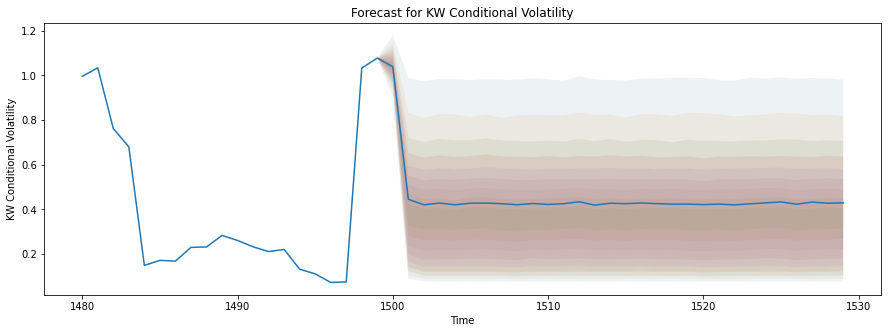

In [78]:
#
# Hmm, I guess I have to look into pyflux code ...
#
model.plot_predict(h=30, figsize=(15,5))